# Causal Discovery mediated by Argumentation

### Graphs and transfomations between packages

In [1]:
import sys
sys.path.append('/vol/bitbucket/fr920/causal-injection')
from utils import plot_DAG, heat_mat

ImportError: cannot import name 'utils' from 'notears' (unknown location)

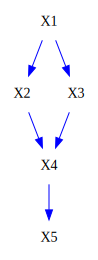

In [3]:
sys.path.append('/vol/bitbucket/fr920/ananke')
from ananke.graphs import ADMG

vertices = ['X1', 'X2', 'X3', 'X4', 'X5']
# di_edges = [('X1', 'X3'), ('X1', 'X4'), ('X1', 'X5'), ('X3', 'X5'), ('X3', 'X4'), ('X4', 'X5'), ('X2', 'X3'), ('X2', 'X5')]
di_edges = [('X1', 'X3'), ('X1', 'X2'), ('X3', 'X4'), ('X2', 'X4'), ('X4', 'X5')]
G = ADMG(vertices, di_edges)
G.draw(direction="TD")

In [3]:
import pydotplus as pdp
import networkx as nx

dotplus = pdp.graph_from_dot_data(G.draw(direction="LR").source)
print(type(dotplus)) # prints <class 'pdp.graphviz.Dot'>
# if graph doesn't have multiedges, use dotplus.set_strict(true)
nx_graph = nx.nx_pydot.from_pydot(dotplus)
print(type(nx_graph)) # prints <class 'nx.classes.multidigraph.MultiDiGraph'>

<class 'pydotplus.graphviz.Dot'>
<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [4]:
# heat_mat(nx.adjacency_matrix(nx_graph).todense().astype(float))
# nx_graph.number_of_nodes()

## Generate data with CDT
https://github.com/FenTechSolutions/CausalDiscoveryToolbox
https://arxiv.org/abs/1903.02278

In [5]:
# from cdt.data import AcyclicGraphGenerator
# generator = AcyclicGraphGenerator('linear', npoints=1000, nodes=5)
# data, graph = generator.generate()
# generator.to_csv('generated_graph')

In [6]:
from cdt.data import AcyclicGraphGenerator
from sklearn.preprocessing import scale
import numpy as np
import pandas as pd
import networkx as nx
from cdt.data.causal_mechanisms import (LinearMechanism,
                                Polynomial_Mechanism,
                                SigmoidAM_Mechanism,
                                SigmoidMix_Mechanism,
                                GaussianProcessAdd_Mechanism,
                                GaussianProcessMix_Mechanism,
                                NN_Mechanism,
                                gmm_cause, normal_noise, uniform_noise)


class DataGenerator(AcyclicGraphGenerator):
    def __init__(self, input_dag, causal_mechanism, noise='gaussian',
                 noise_coeff=.4,
                 initial_variable_generator=gmm_cause,
                 npoints=500, nodes=20, parents_max=5, expected_degree=3,
                 dag_type='default'):
        super(AcyclicGraphGenerator, self).__init__()
        self.mechanism = {'linear': LinearMechanism,
                          'polynomial': Polynomial_Mechanism,
                          'sigmoid_add': SigmoidAM_Mechanism,
                          'sigmoid_mix': SigmoidMix_Mechanism,
                          'gp_add': GaussianProcessAdd_Mechanism,
                          'gp_mix': GaussianProcessMix_Mechanism,
                          'nn': NN_Mechanism}[causal_mechanism]
        if input_dag != None:
            self.g = input_dag
            self.adjacency_matrix = nx.adjacency_matrix(input_dag).todense()
            self.nodes = input_dag.number_of_nodes()
        else:
            self.g = None
            self.adjacency_matrix = np.zeros((nodes, nodes))
            self.nodes = nodes   
            
        self.data = pd.DataFrame(None, columns=["V{}".format(i) for i in range(self.nodes)])
        self.npoints = npoints
        try:
            self.noise = {'gaussian': normal_noise,
                          'uniform': uniform_noise}[noise]
        except KeyError:
            self.noise = noise
        self.noise_coeff = noise_coeff
        
        self.parents_max = parents_max
        self.expected_degree = expected_degree
        self.dag_type = dag_type
        self.initial_generator = initial_variable_generator
        self.cfunctions = None


    def init_variables(self, verbose=False):
        """Redefine the causes, mechanisms and the structure of the graph,
        called by ``self.generate()`` if never called.

        Args:
            verbose (bool): Verbosity
        """
        if self.g == None:
            self.init_dag(verbose)

        # Mechanisms
        self.cfunctions = [self.mechanism(int(sum(self.adjacency_matrix[:, i])),
                                          self.npoints, self.noise, noise_coeff=self.noise_coeff)
                           if sum(self.adjacency_matrix[:, i])
                           else self.initial_generator for i in range(self.nodes)]

    def generate(self, rescale=True):
        """Generate data from an FCM defined in ``self.init_variables()``.

        Args:
            rescale (bool): rescale the generated data (recommended)

        Returns:
            tuple: (pandas.DataFrame, networkx.DiGraph), respectively the
            generated data and graph.
        """
        if self.cfunctions is None:
            self.init_variables()

        for i,j in enumerate(nx.topological_sort(self.g)):
            # Root cause

            if not sum(self.adjacency_matrix[:, i]):
                self.data['V{}'.format(i)] = self.cfunctions[i](self.npoints)
            # Generating causes
            else:
                self.data['V{}'.format(i)] = self.cfunctions[i](self.data.iloc[:, self.adjacency_matrix[:, i].nonzero()[0]].values)
            if rescale:
                self.data['V{}'.format(i)] = scale(self.data['V{}'.format(i)].values)

        return self.data, nx.relabel_nodes(self.g, {j:'V'+str(i) for i,j in enumerate(self.g.nodes)}, copy=True)

if False:
    datagen = DataGenerator(nx_graph,'linear')
    data, graph = datagen.generate()
    nx.draw(graph, with_labels = True)
    heat_mat(nx.adjacency_matrix(graph).todense().astype(float))
    import plotly.express as px
    df = data
    fig = px.scatter_3d(df, x="V1", y="V2",z="V4",  color="V1", size_max=8, opacity=0.7)
    fig.show()



No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


##  Generate data with Causal-learn
https://github.com/cmu-phil/causal-learn

In [2]:
# def simulate_discrete_data(
#         num_of_nodes,
#         sample_size,
#         truth_DAG_directed_edges,
#         random_seed=None):
#     from pgmpy.models.BayesianNetwork import BayesianNetwork
#     from pgmpy.factors.discrete import TabularCPD
#     from pgmpy.sampling import BayesianModelSampling

#     def _simulate_cards():
#         '''
#         why we need this: to calculate cpd of a node with k parents,
#             the conditions to be enumerated is the production of these k parents' cardinalities
#             which will be exponentially slow w.r.t. k.
#             so we want that, if a node has many parents (large k), these parents' cardinalities should be small
#         denote peers_num: peers_num[i, j] = k (where k>0),
#             means that there are k parents pointing to node i, and j is among these k parents.
#         max_peers = peers_num.max(axis=0): the larger max_peers[j], the smaller card[j] should be.
#         '''
#         MAX_ENUMERATION_COMBINATION_NUM = 20
#         in_degrees = adjacency_matrix.sum(axis=1)
#         peers_num = in_degrees[:, None] * adjacency_matrix
#         max_peers_num = peers_num.max(axis=0)
#         max_peers_num[max_peers_num == 0] = 1 # to avoid division by 0 (for leaf nodes)
#         cards = [np.random.randint(2, 1 + max(2, MAX_ENUMERATION_COMBINATION_NUM ** (1. / mpn)))
#                     for mpn in max_peers_num]
#         return cards

#     def _random_alpha():
#         DIRICHLET_ALPHA_LOWER, DIRICHLET_ALPHA_UPPER = 1., 5.
#         return np.random.uniform(DIRICHLET_ALPHA_LOWER, DIRICHLET_ALPHA_UPPER)

#     if random_seed is not None:
#         state = np.random.get_state() # save the current random state
#         np.random.seed(random_seed)  # set the random state to 42 temporarily, just for the following lines
#     adjacency_matrix = np.zeros((num_of_nodes, num_of_nodes))
#     adjacency_matrix[tuple(zip(*truth_DAG_directed_edges))] = 1
#     adjacency_matrix = adjacency_matrix.T

#     cards = _simulate_cards()
#     bn = BayesianNetwork(truth_DAG_directed_edges)  # so isolating nodes will echo error
#     for node in range(num_of_nodes):
#         parents = np.where(adjacency_matrix[node])[0].tolist()
#         parents_card = [cards[prt] for prt in parents]
#         rand_ps = np.array([np.random.dirichlet(np.ones(cards[node]) * _random_alpha()) for _ in
#                             range(int(np.prod(parents_card)))]).T.tolist()

#         cpd = TabularCPD(node, cards[node], rand_ps, evidence=parents, evidence_card=parents_card)
#         bn.add_cpds(cpd)
#     inference = BayesianModelSampling(bn)
#     df = inference.forward_sample(size=sample_size, show_progress=False)
#     topo_order = list(map(int, df.columns))
#     topo_index = [-1] * len(topo_order)
#     for ind, node in enumerate(topo_order): topo_index[node] = ind
#     data = df.to_numpy()[:, topo_index].astype(np.int64)

#     if random_seed is not None: np.random.set_state(state) # restore the random state
#     return data

# def simulate_linear_continuous_data(
#         num_of_nodes,
#         sample_size,
#         truth_DAG_directed_edges,
#         noise_type='gaussian',  # currently: 'gaussian' or 'exponential'
#         random_seed=None,
#         linear_weight_minabs=0.5,
#         linear_weight_maxabs=0.9,
#         linear_weight_netative_prob=0.5):
#     if random_seed is not None:
#         state = np.random.get_state() # save the current random state
#         np.random.seed(random_seed)  # set the random state to 42 temporarily, just for the following lines
#     adjacency_matrix = np.zeros((num_of_nodes, num_of_nodes))
#     adjacency_matrix[tuple(zip(*truth_DAG_directed_edges))] = 1
#     adjacency_matrix = adjacency_matrix.T
#     weight_mask = np.random.uniform(linear_weight_minabs, linear_weight_maxabs, (num_of_nodes, num_of_nodes))
#     weight_mask[np.unravel_index(np.random.choice(np.arange(weight_mask.size), replace=False,
#                 size=int(weight_mask.size * linear_weight_netative_prob)), weight_mask.shape)] *= -1.
#     adjacency_matrix = adjacency_matrix * weight_mask
#     mixing_matrix = np.linalg.inv(np.eye(num_of_nodes) - adjacency_matrix)
#     if noise_type == 'gaussian':
#         exogenous_noise = np.random.normal(0, 1, (num_of_nodes, sample_size))
#     elif noise_type == 'exponential':
#         exogenous_noise = np.random.exponential(1, (num_of_nodes, sample_size))
#     else:
#         raise NotImplementedError
#     data = (mixing_matrix @ exogenous_noise).T  # in shape (sample_size, num_of_nodes)
#     if random_seed is not None: np.random.set_state(state) # restore the random state
#     return data


import os, time
import sys
sys.path.append("")
import unittest
import hashlib
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz, d_separation
from causallearn.graph.SHD import SHD
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.TXT2GeneralGraph import txt2generalgraph
from tests.utils_simulate_data import simulate_discrete_data, simulate_linear_continuous_data

### Use CL example DAG 

/vol/bitbucket/fr920/envs/torchinject/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


  0%|          | 0/5 [00:00<?, ?it/s]

Depth=0, working on node X1
X1 _|/|_ X2 | [] with p-value 0.000000

X1 _|/|_ X3 | [] with p-value 0.000001

X1 _|/|_ X4 | [] with p-value 0.000000

X1 _|/|_ X5 | [] with p-value 0.000593

Depth=0, working on node X2
X2 _|/|_ X1 | [] with p-value 0.000000

X2 _|/|_ X3 | [] with p-value 0.000000

X2 _|/|_ X4 | [] with p-value 0.000000

X2 _|/|_ X5 | [] with p-value 0.000000

Depth=0, working on node X3
X3 _|/|_ X1 | [] with p-value 0.000001

X3 _|/|_ X2 | [] with p-value 0.000000

X3 _|/|_ X4 | [] with p-value 0.000000

X3 _|/|_ X5 | [] with p-value 0.000000

Depth=0, working on node X4
X4 _|/|_ X1 | [] with p-value 0.000000

X4 _|/|_ X2 | [] with p-value 0.000000

X4 _|/|_ X3 | [] with p-value 0.000000

X4 _|/|_ X5 | [] with p-value 0.000000

Depth=0, working on node X5
X5 _|/|_ X1 | [] with p-value 0.000593

X5 _|/|_ X2 | [] with p-value 0.000000

X5 _|/|_ X3 | [] with p-value 0.000000

X5 _|/|_ X4 | [] with p-value 0.000000

Depth=1, working on node X1
X1 _|/|_ X2 | ['X3'] with p-valu

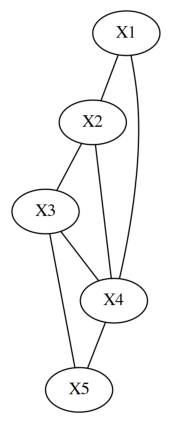

Starting Orientation by Separating Set
(0, 1, 2)
(1, 2, 4)
(0, 3, 2)
all(y=3 not in S for S in cg.sepset[0, 2]=[(), (), (1,), (1,)])
Oriented: x=0 --> y=3 (X1 --> X4)
Oriented: z=2 --> y=3 (X3 --> X4)
(0, 3, 4)
(1, 3, 4)
Starting propagation by Meek Rules (Meek, 1995)
---------------- Processing Unshielded Triples ----------------
0 --> 3 and 3 -- 4
4 is not ancestor of 3
Oriented: j=3 --> k=4 (X4 --> X5)
---------------- Processing Triangles ----------------
(1, 0, 3) is Tri
(3, 0, 1) is Tri
(0, 1, 3) is Tri
(2, 1, 3) is Tri
(3, 1, 0) is Tri
(3, 1, 2) is Tri
(1, 2, 3) is Tri
(3, 2, 1) is Tri
(3, 2, 4) is Tri
(4, 2, 3) is Tri
(1, 3, 0) is Tri
(1, 3, 2) is Tri
(4, 3, 2) is Tri
(2, 4, 3) is Tri
(3, 4, 2) is Tri
(0, 3, 1) is Tri
(2, 3, 1) is Tri
(2, 3, 4) is Tri
2 --> 3 and 3 --> 4 and 2 -- 4
Oriented: i=2 --> k=4 (X3 --> X5)
---------------- Processing Kites ----------------
(1, 0, 2, 3) is Kite
1 -- 0 and 1 -- 2 and 0 --> 3 and 2 --> 3 and 1 -- 3
Oriented: i=1 --> l=3 (X2 --> X4)
(3, 0,

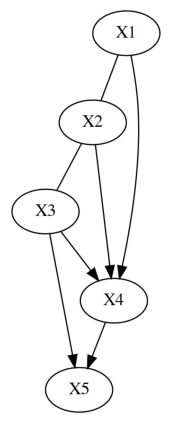

In [1]:
# Graph specification.
num_of_nodes = 5
truth_DAG_directed_edges = {(0, 1), (0, 3), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4)}
truth_CPDAG_directed_edges = {(0, 3), (1, 3), (2, 3), (2, 4), (3, 4)}
truth_CPDAG_undirected_edges = {(0, 1), (1, 2), (2, 1), (1, 0)}
# After the skeleton is discovered, the edges are oriented in the following way:
# Unshilded triples:
#   2 -- 1 -- 0: not v-structure.
#   1 -- 2 -- 4: not v-structure.
#   0 -- 3 -- 2: v-structure, oritented as 0 -> 3 <- 2.
#   0 -- 3 -- 4: not v-structure.
#   1 -- 3 -- 4: not v-structure.
# Then by Meek rule 1: 3 -> 4.
# Then by Meek rule 2: 2 -> 4.
# Then by Meek rule 3: 1 -> 3.

###### Simulation configuration: code to generate "./TestData/test_pc_simulated_linear_gaussian_data.txt" ######
# data = simulate_linear_continuous_data(num_of_nodes, 10000, truth_DAG_directed_edges, "gaussian", 42)
###### Simulation configuration: code to generate "./TestData/test_pc_simulated_linear_gaussian_data.txt" ######

# this simple graph is the same as in test_pc_simulate_linear_gaussian_with_fisher_z.

# from cdt.data import load_dataset
# data, graph = load_dataset("sachs")
# data = data.to_numpy()

### binary dataset
# import bnlearn as bn
# bif_file= 'sachs'
# data = bn.import_DAG(bif_file, verbose=1).to_numpy()
def checkEqual(L1, L2, output_message):
    # if type(L1) != list:
    #     L1 = list(L1)
    #     L2 = list(L2)

    if set(L1)!=set(L2):
        return print(output_message)       

if True:
    # data = simulate_linear_continuous_data(num_of_nodes, 1000, truth_DAG_directed_edges, "exponential", 42)
    data = simulate_discrete_data(num_of_nodes, 10000, truth_DAG_directed_edges, 42)
    ## there is no randomness in data generation (with seed fixed for simulate_data).
    ## however, there still exists randomness in KCI (null_sample_spectral).
    ## for this simple test, we can assume that KCI always returns the correct result (despite randomness).

    # Run PC with default parameters: stable=True, uc_rule=0 (uc_sepset), uc_priority=2 (prioritize existing colliders)
    # cg = pc(data=data, alpha=0.05, stable=True, uc_rule=0, uc_priority=-1, show_progress=True, indep_test='gsq')
    # Run PC with: stable=True, uc_rule=0 (uc_sepset), uc_priority=0 (overwrite)
    cg = pc(data, 0.05, gsq)
    cg.draw_pydot_graph()
    # returned_directed_edges = set(cg.find_fully_directed())
    # returned_undirected_edges = set(cg.find_undirected())
    # returned_bidirected_edges = set(cg.find_bi_directed())
    # checkEqual(truth_CPDAG_directed_edges, returned_directed_edges, "Directed edges are not correct.")
    # checkEqual(truth_CPDAG_undirected_edges, returned_undirected_edges, "Undirected edges are not correct.")
    # print("There should be no bi-directed edges.") if 0!=len(returned_bidirected_edges) else print("finished")
    # print(f"    pc(data, 0.05, kci)\treturns exactly the same CPDAG as the truth.")

    ### R implementation
    # import networkx as nx
    # from cdt.causality.graph import PC
    # from cdt.data import load_dataset
    # data, graph = load_dataset("sachs")
    # obj = PC()
    # #The predict() method works without a graph, or with a
    # #directed or undirected graph provided as an input
    # output = obj.predict(data)    #No graph provided as an argument
    # output = obj.predict(data, nx.Graph(graph))  #With an undirected graph
    # output = obj.predict(data, graph)  #With a directed graph
    # #To view the graph created, run the below commands:
    # nx.draw_networkx(output, font_size=8)
    # plt.show()

In [8]:
# from ananke.graphs import ADMG
# vertices = list(str(i) for i in range(5))
# print(vertices)
# di_edges = [('0', '1'), 
#             ('0', '3'), 
#             ('1', '2'), 
#             ('1', '3'), 
#             ('2', '3'), 
#             ('2', '4'), 
#             ('3', '4')]
            
# G = ADMG(vertices, di_edges)
# G.draw(direction="TB")

['X1', 'X2', 'X3', 'X4', 'X5']


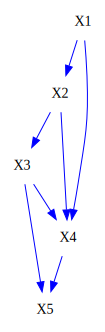

In [9]:
from ananke.graphs import ADMG
vertices = list('X'+str(i+1) for i in range(5))
print(vertices)
di_edges = [('X1', 'X2'), 
            ('X1', 'X4'), 
            ('X2', 'X3'), 
            ('X2', 'X4'), 
            ('X3', 'X4'), 
            ('X3', 'X5'), 
            ('X4', 'X5')]
            
G = ADMG(vertices, di_edges)
G.draw(direction="TB")

### Example form PC-stable (Colombo and Maathuis, 2014)
https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf

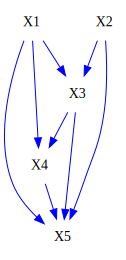

In [3]:
from ananke.graphs import ADMG

vertices = ['X1', 'X2', 'X3', 'X4', 'X5']
di_edges = [('X1', 'X3'), ('X1', 'X4'), ('X1', 'X5'), ('X3', 'X5'), ('X3', 'X4'), ('X4', 'X5'), ('X2', 'X3'), ('X2', 'X5')]
G = ADMG(vertices, di_edges)
G.draw(direction="TD")

/vol/bitbucket/fr920/envs/torchinject/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
/vol/bitbucket/fr920/envs/torchinject/lib/python3.9/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Depth=0, working on node X1
X1 _||_ X2 | [] with p-value 0.280500

X1 _|/|_ X3 | [] with p-value 0.000000

X1 _|/|_ X4 | [] with p-value 0.000000

X1 _|/|_ X5 | [] with p-value 0.000000

Depth=0, working on node X2
X2 _||_ X1 | [] with p-value 0.280500

X2 _|/|_ X3 | [] with p-value 0.008142

X2 _||_ X4 | [] with p-value 0.183289

X2 _|/|_ X5 | [] with p-value 0.001546

Depth=0, working on node X3
X3 _|/|_ X1 | [] with p-value 0.000000

X3 _|/|_ X2 | [] with p-value 0.008142

X3 _|/|_ X4 | [] with p-value 0.000000

X3 _|/|_ X5 | [] with p-value 0.000002

Depth=0, working on node X4
X4 _|/|_ X1 | [] with p-value 0.000000

X4 _||_ X2 | [] with p-value 0.183289

X4 _|/|_ X3 | [] with p-value 0.000000

X4 _|/|_ X5 | [] with p-value 0.000000

Depth=0, working on node X5
X5 _|/|_ X1 | [] with p-value 0.000000

X5 _|/|_ X2 | [] with p-value 0.001546

X5 _|/|_ X3 | [] with p-value 0.000002

X5 _|/|_ X4 | [] with p-value 0.000000

Removing X1 -- X2. Sepset: [(), ()] p-value [{(): 0.280499918550

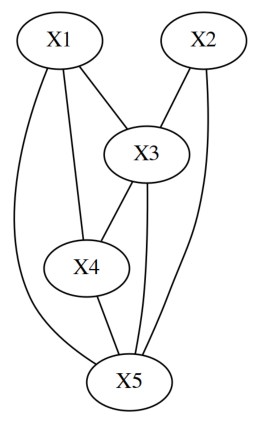

Starting Orientation by Separating Set
(0, 2, 1)
all(y=2 not in S for S in cg.sepset[0, 1]=[(), ()])
Oriented: x=0 --> y=2 (X1 --> X3)
Oriented: z=1 --> y=2 (X2 --> X3)
(1, 2, 3)
all(y=2 not in S for S in cg.sepset[1, 3]=[(), ()])
Oriented: x=1 --> y=2 (X2 --> X3)
Oriented: z=3 --> y=2 (X4 --> X3)
(0, 4, 1)
all(y=4 not in S for S in cg.sepset[0, 1]=[(), ()])
Oriented: x=0 --> y=4 (X1 --> X5)
Oriented: z=1 --> y=4 (X2 --> X5)
(1, 4, 3)
all(y=4 not in S for S in cg.sepset[1, 3]=[(), ()])
Oriented: x=1 --> y=4 (X2 --> X5)
Oriented: z=3 --> y=4 (X4 --> X5)
Starting propagation by Meek Rules (Meek, 1995)
---------------- Processing Unshielded Triples ----------------
---------------- Processing Triangles ----------------
(2, 0, 3) is Tri
(2, 0, 4) is Tri
(3, 0, 2) is Tri
(3, 0, 4) is Tri
(4, 0, 3) is Tri
(4, 0, 2) is Tri
(2, 1, 4) is Tri
(4, 1, 2) is Tri
(4, 2, 0) is Tri
(4, 2, 1) is Tri
(4, 2, 3) is Tri
(0, 3, 2) is Tri
(0, 3, 4) is Tri
(2, 3, 0) is Tri
(2, 3, 4) is Tri
(4, 3, 0) is Tri
(4

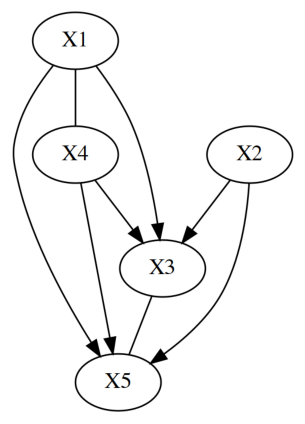

In [3]:
num_of_nodes = 5
truth_DAG_directed_edges = {(0, 2), (0, 3), (0, 4), (2, 4), (2, 3), (3, 4), (1, 2), (1, 4)}

data = simulate_discrete_data(num_of_nodes, 10000, truth_DAG_directed_edges, 42)
## there is no randomness in data generation (with seed fixed for simulate_data).
## however, there still exists randomness in KCI (null_sample_spectral).
## for this simple test, we can assume that KCI always returns the correct result (despite randomness).

# Run PC with default parameters: stable=True, uc_rule=0 (uc_sepset), uc_priority=2 (prioritize existing colliders)
# cg = pc(data=data, alpha=0.05, stable=True, uc_rule=0, uc_priority=-1, show_progress=True, indep_test='gsq')
# Run PC with: stable=True, uc_rule=0 (uc_sepset), uc_priority=0 (overwrite)
cg = pc(data, 0.05, ikb=False
# , uc_rule=1, uc_priority=3
)
cg.draw_pydot_graph()

## Worked example

/vol/bitbucket/fr920/envs/torchinject/lib/python3.9/site-packages/pgmpy/utils/mathext.py:83: UserWarning: Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
  warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Depth=0, working on node X1
X1 _||_ X2 | [] with p-value 0.280500

X1 _|/|_ X3 | [] with p-value 0.000000

X1 _|/|_ X4 | [] with p-value 0.000000

X1 _|/|_ X5 | [] with p-value 0.000000

Depth=0, working on node X2
X2 _||_ X1 | [] with p-value 0.280500

X2 _|/|_ X3 | [] with p-value 0.008142

X2 _||_ X4 | [] with p-value 0.183289

X2 _|/|_ X5 | [] with p-value 0.001546

Depth=0, working on node X3
X3 _|/|_ X1 | [] with p-value 0.000000

X3 _|/|_ X2 | [] with p-value 0.008142

X3 _|/|_ X4 | [] with p-value 0.000000

X3 _|/|_ X5 | [] with p-value 0.000002

Depth=0, working on node X4
X4 _|/|_ X1 | [] with p-value 0.000000

X4 _||_ X2 | [] with p-value 0.183289

X4 _|/|_ X3 | [] with p-value 0.000000

X4 _|/|_ X5 | [] with p-value 0.000000

Depth=0, working on node X5
X5 _|/|_ X1 | [] with p-value 0.000000

X5 _|/|_ X2 | [] with p-value 0.001546

X5 _|/|_ X3 | [] with p-value 0.000002

X5 _|/|_ X4 | [] with p-value 0.000000

Removing X1 -- X2. Sepset: [(), ()] p-value [{(): 0.280499918550

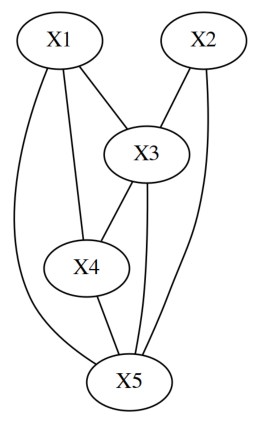

Starting Orientation by MaxP (Ramsey, 2016)
(0, 2, 1)
Neighbours of 0: [2 3 4], PWS: [(), (2,), (3,), (4,), (2, 3), (2, 4), (3, 4), (2, 3, 4)]
Neighbours of 1: [2 4], PWS: [(), (2,), (4,), (2, 4)]
Conditional sets with 2: [(2, 4), (2,), (2, 3), (2, 3, 4)]
Neighbours of 0: [2 3 4], PWS: [(), (2,), (3,), (4,), (2, 3), (2, 4), (3, 4), (2, 3, 4)]
Neighbours of 1: [2 4], PWS: [(), (2,), (4,), (2, 4)]
cond_with_y: [{0.21186437705166083, (2, 4)}, {0.35211822452124286, (2,)}, {(2, 3), 0.39352305918820707}, {0.2276075109545901, (2, 3, 4)}]
Neighbours of 0: [2 3 4], PWS: [(), (2,), (3,), (4,), (2, 3), (2, 4), (3, 4), (2, 3, 4)]
Neighbours of 1: [2 4], PWS: [(), (2,), (4,), (2, 4)]
cond_without_y:[{0.24713719891384578, (3, 4)}, {0.16133422702360378, (4,)}, {0.28049991855060963, ()}, {0.42707954273388005, (3,)}]
max_p_not_contain_y > max_p_contain_y 0.42707954273388005 0.39352305918820707
Chosen: [{0.42707954273388005, (3,)}]
(1, 2, 3)
Neighbours of 1: [2 4], PWS: [(), (2,), (4,), (2, 4)]
Neighbou

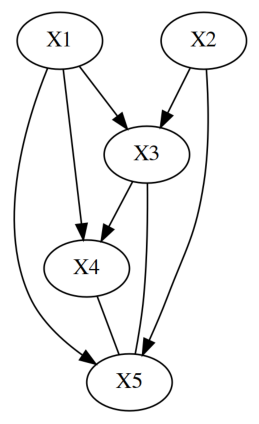

In [1]:

import os, time
import sys
sys.path.append("")
import unittest
import hashlib
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz, d_separation
from causallearn.graph.SHD import SHD
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.TXT2GeneralGraph import txt2generalgraph
from tests.utils_simulate_data import simulate_discrete_data, simulate_linear_continuous_data

num_of_nodes=5
truth_DAG_directed_edges = {(0, 2), (0, 3), (0, 4), (2, 4), (2, 3), (3, 4), (1, 2), (1, 4)}

data = simulate_discrete_data(num_of_nodes, 10000, truth_DAG_directed_edges, 42)
## there is no randomness in data generation (with seed fixed for simulate_data).
## however, there still exists randomness in KCI (null_sample_spectral).
## for this simple test, we can assume that KCI always returns the correct result (despite randomness).

# Run PC with default parameters: stable=True, uc_rule=0 (uc_sepset), uc_priority=2 (prioritize existing colliders)
# cg = pc(data=data, alpha=0.05, stable=True, uc_rule=0, uc_priority=-1, show_progress=True, indep_test='gsq')
# Run PC with: stable=True, uc_rule=0 (uc_sepset), uc_priority=0 (overwrite)
#### Majority and Conservative are not implemented
#### Also check Consistent implementation 
cg = pc(data, 0.05, ikb=False
, uc_rule=1 #(maxP)
# , uc_rule=2 #(definiteMaxP)
, uc_priority=4 #(whatever is default in uc_rule, i.e. 3 (prioritize stronger colliders))
# , uc_priority=0 #(overwrite)
)
cg.draw_pydot_graph()

### Checks

In [14]:
x=1
z=3
S={}
cg.ci_test(x, z, S)
# cg.ci_test(x, z, {})

0.18328946670338997

In [15]:
x=1
z=3
S={2}
cg.ci_test(x, z, S)
# cg.ci_test(x, z, {})

0.6595075132442088

In [16]:
x=1
z=3
S={0}
cg.ci_test(x, z, S)
# cg.ci_test(x, z, {})

0.2660957835894022

In [17]:
x=1
z=3
S={0,2}
cg.ci_test(x, z, S)
# cg.ci_test(x, z, {})

0.8122593823951494

In [2]:
# pd.DataFrame(
cg.IKB_list
# )

## Pearl Axiomatic Representation

https://www.kybernetika.cz/content/1989/7/33/paper.pdf

"It is easy to verify that the set of statements I(X, Z, Y)P generated by any probability distribution P must obey the following set of axioms:"

Symmetry 

(1.a) $I(X,Z,Y)\implies I(Y,Z,X)$

Decomposition 

(1.b) $I(X, Z, Y \cup W)\implies I(X, Z, Y) \land I(X, Z, W) $

Weak Union 

(1.c) $I(X, Z, Y \cup W)\implies I(X, Z \cup W,Y) $

Contraction 

(1.d) $I(X, Z \cup Y, W) \land I(X, Z, Y) \cup I(X, Z,Y \cup W) $

If P is strictly positive, than a fifth axiom holds: 

Intersection 

(1.e) $I(X, Z \cup W, Y) \land I(X, Z\cup Y, W) \implies I(X, Z,Y \cup W)$

For Bayesian Networks only

Weak Transitivity

$I(X, Z, Y) \land I(X, Z \cup \gamma, Y ) \implies I(X, Z, \gamma) \lor I(\gamma, Z, Y)$

In [2]:
verb = True

from tqdm.notebook import tqdm
# class All:
#     def __init__(self, conditions):
#         self.index = []
#         for i, cond in enumerate(conditions):
#             if not cond:
#                 self.index.append(i)
#     def __bool__(self):
#         return len(self.index)>0
# if o := All([2 > 1, 9 < 10, 2 == 1]):
#        print(f'The Failed conditions are {o.index}')
       
class test_obj( object ):
    def __init__(self, X:set, S:set, Y:set, p_val:float=None, dep_type:str="I", alpha:float=0.01 ):
        self.X= X
        self.Y= Y
        self.S= S
        self.p_val = p_val
        if p_val == None:
            self.dep_type = dep_type
        else:
            self.dep_type = "D" if p_val < alpha else "I"

    def to_list(self, p=False)->list:
        if p:
            return [self.X, self.S, self.Y, self.p_val, self.dep_type]
        else:
            return [self.X, self.S, self.Y, self.dep_type]

    def elements(self):
        return (self.X, self.S, self.Y)

    def negate(self):
        if self.dep_type=="D":
            self.dep_type="I"
        else:
            self.dep_type="D"
        return self

    ## Symmetry
    def symmetrise(self, verbose=verb):
        if self.dep_type=="I":
            return test_obj(X=self.Y, S=self.S, Y=self.X, p_val=self.p_val, dep_type=self.dep_type)

    ## Decomoposition
    def decompose(self, verbose=verb)->list:
        assert len(self.Y)>=2
        return_list=[]
        for item in self.Y:
            return_list.append(test_obj(self.X,self.S,{item}))
        if verbose:
            print("Decompose:",{'P':self.to_list(), 'C':[item.to_list() for item in return_list]})
        return return_list #NOTE: add pval

    ## Weak Union
    def weak_union(self, verbose=verb)->list:
        assert len(self.Y)>=2
        Y, W = self.Y
        if verbose:
            print("Weak Union:",{'P':self.to_list(), 'C':[self.X, self.S.union({W}), {Y}, self.dep_type]})
        return [test_obj(self.X, self.S.union({W}), {Y})] #NOTE: add pval


test=test_obj(X={0},Y={1,4},S={2,3})
print(f"Initial test: [{test.to_list()}] i.e. {test.X} _||_ {test.Y} | {test.S} ")

## Decomposition
print(f"Apply Decomposition: {test.decompose()}")

## Weak Union
print(f"Apply Weak Union: {test.weak_union()}")

test1=test_obj(X={0}, Y={1,5}, S={2,3})
test2=test_obj(X={0}, Y={4}, S={2,1,3,5})
print(f"Initial tests: {test1.to_list()} & {test2.to_list()}")

## Contraction
def contract(test1:test_obj, test2:test_obj, verbose=verb)->test_obj:
    ##NOTE: need to take care of different lenghts because it then come decomposition
    
    conditions = [len(test1.S)>0 , len(test2.S)>0 , test1.dep_type==test2.dep_type=='I' , test1.X==test2.X , test1.Y!=test2.Y , test1.Y<test2.S, test2.S-test1.Y==test1.S]
    if all(conditions):
        if verbose:
            print("Contraction:", {'P':[test1.to_list(), test2.to_list()],'C':[test1.X, test1.S , test1.Y.union(test2.Y), test1.dep_type]})
        return test_obj(test1.X, test1.S , test1.Y.union(test2.Y))
    # elif o := All(conditions):
            # print(f'Contraction False conditions: {np.array(["len(test1.S)>0" , "len(test1.S)>0" , "test1.dep_type==test1.dep_type==I", "test1.X == test2.X", "test1.Y != test2.Y", "test1.Y.issubset(test2.S)"])[o.index]}')
            # print(f"Failed conditions:{o.index}")
print(f"Apply Contraction: {contract(test1, test2)}")

def contract_decompose(test1:test_obj, test2:test_obj)->list:
    contracted= contract(test1, test2)
    if type(contracted) == test_obj:
        return contracted.decompose()
    else:
        return contracted

def contract_wunite(test1:test_obj, test2:test_obj)->list:
    contracted= contract(test1, test2)
    if type(contracted) == test_obj:
        return contracted.weak_union()
    else:
        return contracted

print(f"Apply Decomposition to the Contraction: {contract_decompose(test1, test2)}")

test1=test_obj(X={0}, Y={1}, S={2,4,3})
test2=test_obj(X={0}, Y={4}, S={2,1,3})
print(f"Initial tests: {test1.to_list()} & {test2.to_list()}")

def intersect(test1:test_obj, test2:test_obj, verbose=verb)->list:
    Z = test1.S.intersection(test2.S)
    W = test1.S - Z
    Y = test2.S - Z
    # if len(test1.S)==len(test1.S)>0 and test1.dep_type==test1.dep_type=='I' and test1.X == test2.X and Z1==Z2 and test1.Y.issubset(test2.S):
    #     return {'P':[test1.to_list(), test2.to_list()],'C':[test1.X, Z1 , test1.Y.union(test2.Y), test1.dep_type]}
    conditions = [len(test1.S)==len(test2.S)>0 , test1.dep_type==test2.dep_type=='I' , test1.X == test2.X , W==test2.Y, test1.Y==Y , test1.Y < test2.S ]
    if all(conditions):
        if verbose:
            print("Intersection:", {'P':[test1.to_list(), test2.to_list()],'C':[test1.X, Z , test1.Y.union(test2.Y), test1.dep_type]})
        return test_obj(test1.X, Z , test1.Y.union(test2.Y))
    # elif o := All(conditions):
    #         print(f'Intersection False conditions: {np.array(["len(test1.S)==len(test1.S)>0" , "test1.dep_type==test1.dep_type==I" , "test1.X == test2.X" , "Z1==Z2" , "test1.Y.issubset(test2.S)"])[o.index]}')
            # print(f"Failed conditions:{o.index}")

print(f"Apply Intersection: {intersect(test1, test2)}")

def intersect_decompose(test1:test_obj, test2:test_obj)->list:
    intersected= intersect(test1, test2)
    if type(intersected) == test_obj:
        return intersected.decompose()

def intersect_wunite(test1:test_obj, test2:test_obj)->list:
    intersected= intersect(test1, test2)
    if type(intersected) == test_obj:
        return intersected.weak_union()

print(f"Apply Decomposition to the Intersection: {intersect_decompose(test1, test2)}")

test1=test_obj(X={0}, Y={1}, S={2,})
test2=test_obj(X={0}, Y={1}, S={2,3})
print(f"Initial tests: {test1.to_list()} & {test2.to_list()}")

#### Additional Rules for Bayesian Networks

def make_lor_single_head(P1:test_obj, P2:test_obj, C1:test_obj, C2:test_obj, verbose=verb)->list:
    R1= {'P':[P1.to_list(),P2.to_list(),C1.negate().to_list()],'C':[C2.to_list()]}
    R2= {'P':[P1.to_list(),P2.to_list(),C2.negate().to_list()],'C':[C1.to_list()]}
    R3= {'P':[P1.to_list(),C1.negate().to_list(),C2.negate().to_list()],'C':[P2.negate().to_list()]}
    R4= {'P':[P2.to_list(),C1.negate().to_list(),C2.negate().to_list()],'C':[P1.negate().to_list()]}
    if verbose:
        print({key: [value] + [R2[key]] + [R3[key]] + [R4[key]] for key, value in R1.items()})
    return [P1,P2,C1.negate(),C2] + [P1,P2,C2.negate(),C1] + [P1,C2.negate(),C1.negate(),P2.negate()] + [P2,C2.negate(),C1.negate(),P1.negate()] 

## Weak Transitiviy
def weak_transitivity(test1:test_obj, test2:test_obj, verbose=verb)->dict:
    Z = test1.S.intersection(test2.S)
    W = test2.S - Z
    # if len(test1.S)==len(test1.S)>0 and test1.dep_type==test1.dep_type=='I' and test1.X == test2.X and Z1==Z2 and test1.Y.issubset(test2.S):
    #     return {'P':[test1.to_list(), test2.to_list()],'C':[test1.X, Z1 , test1.Y.union(test2.Y), test1.dep_type]}
    conditions = [len(test1.S)>0, len(test2.S)>0, test1.dep_type==test2.dep_type=='I', test1.X==test2.X, test1.Y==test2.Y, test1.S<test2.S ]
    if all(conditions):
        P00 = test_obj(test1.X, test1.S, test1.Y)
        P01 = test_obj(test2.X, test2.S, test2.Y)
        C00 = test_obj(test1.X, test1.S, W)
        C01 = test_obj(W, test1.S, test1.Y)
        if verbose:
            print("Weak Transitivity:", make_lor_single_head(P00,P01,C00,C01))
        return make_lor_single_head(P00,P01,C00,C01)

print(f"Apply Weak Transitivity: {weak_transitivity(test1, test2)}")


test1=test_obj(X={0}, Y={1}, S={2,3})
test2=test_obj(X={2}, Y={3}, S={0,1})
print(f"Initial tests: {test1.to_list()} & {test2.to_list()}")

## Chordiality
def chordiality(test1:test_obj, test2:test_obj)->dict:
    assert len(test1.S)==2
    assert len(test2.S)==2
    assert test1.X.union(test1.Y) == test2.S
    assert test2.X.union(test2.Y) == test1.S
    X2, Y2 = test1.S
    P00 = test_obj(test1.X, test1.S, test1.Y)
    P01 = test_obj(test2.X, test2.S, test2.Y)
    C00 = test_obj(test1.X, {X2}, test1.Y)
    C01 = test_obj(test1.X, {Y2}, test1.Y)
    return make_lor_single_head(P00,P01,C00,C01)

print(f"Apply Chordiality: {chordiality(test1, test2)}")
print("="*100)

## Composition
def compose(test1:test_obj, test2:test_obj)->list:
    raise NotImplementedError

############ APPLY RULES ###############

# IKB_axioms = cg.IKB_list.copy()
# import itertools

# for test in tqdm(cg.IKB_list):
#     if test.dep_type=="I":
#         add = test.symmetrise()
#         if add != None and add.elements() not in [test.elements() for test in IKB_axioms]:
#             IKB_axioms.append(add)
# print("Tests added by symmetry:",len(IKB_axioms)-len(cg.IKB_list))

# for (a,b) in itertools.combinations(IKB_axioms, 2):
#     add = contract_decompose(a,b)
#     if add != None and [a.elements() not in [test.elements() for test in IKB_axioms] for a in add]:
#         # print(f"Contraction: {add}")
#         IKB_axioms=IKB_axioms+add
#     add = intersect_decompose(a,b)
#     if add != None and [a.elements() not in [test.elements() for test in IKB_axioms] for a in add]:
#         # print(f"Intersection: {add}")
#         IKB_axioms=IKB_axioms+add
#     add = contract_wunite(a,b)
#     if add != None and [a.elements() not in [test.elements() for test in IKB_axioms] for a in add]:
#         # print(f"Contraction w: {add}")
#         IKB_axioms=IKB_axioms+add
#     add = intersect_wunite(a,b)
#     if add != None and [a.elements() not in [test.elements() for test in IKB_axioms] for a in add]:
#         # print(f"Intersection w: {add}")
#         IKB_axioms=IKB_axioms+add
#     # add = weak_transitivity(a,b)
#     # if add != None and [a.elements() not in [test.elements() for test in IKB_axioms] for a in add]:
#     #     # print(f"w transit: {add}")
#     #     IKB_axioms=IKB_axioms+add

# print("Tests added:",len(IKB_axioms)-len(cg.IKB_list))

Initial test: [[{0}, {2, 3}, {1, 4}, 'I']] i.e. {0} _||_ {1, 4} | {2, 3} 
Decompose: {'P': [{0}, {2, 3}, {1, 4}, 'I'], 'C': [[{0}, {2, 3}, {1}, 'I'], [{0}, {2, 3}, {4}, 'I']]}
Apply Decomposition: [<__main__.test_obj object at 0x7f998059b9a0>, <__main__.test_obj object at 0x7f99805e8e50>]
Weak Union: {'P': [{0}, {2, 3}, {1, 4}, 'I'], 'C': [{0}, {2, 3, 4}, {1}, 'I']}
Apply Weak Union: [<__main__.test_obj object at 0x7f9960f79dc0>]
Initial tests: [{0}, {2, 3}, {1, 5}, 'I'] & [{0}, {1, 2, 3, 5}, {4}, 'I']
Contraction: {'P': [[{0}, {2, 3}, {1, 5}, 'I'], [{0}, {1, 2, 3, 5}, {4}, 'I']], 'C': [{0}, {2, 3}, {1, 4, 5}, 'I']}
Apply Contraction: <__main__.test_obj object at 0x7f998f2c6610>
Contraction: {'P': [[{0}, {2, 3}, {1, 5}, 'I'], [{0}, {1, 2, 3, 5}, {4}, 'I']], 'C': [{0}, {2, 3}, {1, 4, 5}, 'I']}
Decompose: {'P': [{0}, {2, 3}, {1, 4, 5}, 'I'], 'C': [[{0}, {2, 3}, {1}, 'I'], [{0}, {2, 3}, {4}, 'I'], [{0}, {2, 3}, {5}, 'I']]}
Apply Decomposition to the Contraction: [<__main__.test_obj object

### checks

In [58]:
x = 1
y = 2
alpha=0.01
print([s for s in [list(s.keys())[0] for s in cg.IKB[x,y]]])
print([r>0.01 for r in [list(s.values())[0] for s in cg.IKB[x,y]]])
print([list(s.values()) for s in cg.IKB[x,y] ])
[s for s,p in [list(s.items())[0] for s in cg.IKB[x,y]] if p > alpha]###with dups
{a:t for a,t in set([tuple(s.items())[0] for s in cg.IKB[x,y]]) if t>alpha}###deduped



[(), (), (4,), (4,), (2, 3), (3, 4), (1, 2), (0, 3, 4)]
[False, False, True, True, False, True, False, True]
[[0.008141753727785028], [0.008141753727785028], [0.01239853067770258], [0.01239853067770258], [0.0], [0.025384581210297963], [0.00010506902121143469], [0.02374118484552712]]


{(3, 4): 0.025384581210297963,
 (4,): 0.01239853067770258,
 (0, 3, 4): 0.02374118484552712}

In [22]:
len(cg.IKB_list)
# len(IKB_axioms)


101

In [7]:
for test in cg.IKB_list:
    print(test.X, test.S, test.Y, test.dep_type)

{0} set() {1} I
{0} set() {2} D
{0} set() {3} D
{0} set() {4} D
{1} set() {0} I
{1} set() {2} D
{1} set() {3} I
{1} set() {4} D
{2} set() {0} D
{2} set() {1} D
{2} set() {3} D
{2} set() {4} D
{3} set() {0} D
{3} set() {1} I
{3} set() {2} D
{3} set() {4} D
{4} set() {0} D
{4} set() {1} D
{4} set() {2} D
{4} set() {3} D
{0} {3} {2} D
{0} {4} {2} D
{0} {2} {3} D
{0} {4} {3} D
{0} {2} {4} D
{0} {3} {4} D
{1} {4} {2} D
{1} {2} {4} D
{2} {1} {0} D
{2} {3} {0} D
{2} {4} {0} D
{2} {0} {1} D
{2} {3} {1} D
{2} {4} {1} D
{2} {0} {3} D
{2} {1} {3} D
{2} {4} {3} D
{2} {0} {4} D
{2} {1} {4} D
{2} {3} {4} D
{3} {2} {0} D
{3} {4} {0} D
{3} {0} {2} D
{3} {4} {2} D
{3} {0} {4} D
{3} {2} {4} D
{4} {1} {0} D
{4} {2} {0} D
{4} {3} {0} D
{4} {0} {1} D
{4} {2} {1} D
{4} {3} {1} D
{4} {0} {2} D
{4} {1} {2} D
{4} {3} {2} D
{4} {0} {3} D
{4} {1} {3} D
{4} {2} {3} D
{0} {3, 4} {2} D
{0} {2, 4} {3} D
{0} {2, 3} {4} D
{2} {1, 3} {0} D
{2} {1, 4} {0} D
{2} {3, 4} {0} D
{2} {0, 3} {1} D
{2} {0, 4} {1} D
{2} {3, 4} {

In [23]:
len(IKB_axioms)
# len(IKB_axioms)


113

In [78]:
for test in IKB_axioms:
    print(test.X, test.S, test.Y, test.dep_type, test.p_val)

{0} set() {1} I 0.28049991855060963
{0} set() {2} D 1.2456580877895362e-08
{0} set() {3} D 0.0
{0} set() {4} D 0.0
{1} set() {0} I 0.28049991855060963
{1} set() {2} D 0.008141753727785028
{1} set() {3} I 0.18328946670338997
{1} set() {4} D 0.0015464550116344178
{2} set() {0} D 1.2456580877895362e-08
{2} set() {1} D 0.008141753727785028
{2} set() {3} D 0.0
{2} set() {4} D 2.3337252705868394e-06
{3} set() {0} D 0.0
{3} set() {1} I 0.18328946670338997
{3} set() {2} D 0.0
{3} set() {4} D 1.2599164667115303e-07
{4} set() {0} D 0.0
{4} set() {1} D 0.0015464550116344178
{4} set() {2} D 2.3337252705868394e-06
{4} set() {3} D 1.2599164667115303e-07
{0} {3} {2} D 0.011876041598795517
{0} {4} {2} D 5.641767053532476e-10
{0} {2} {3} D 0.0
{0} {4} {3} D 0.0
{0} {2} {4} D 0.0
{0} {3} {4} D 0.0
{1} {4} {2} D 0.01239853067770258
{1} {2} {4} D 0.0023255727177968755
{2} {1} {0} D 1.4553444227516366e-08
{2} {3} {0} D 0.011876041598795517
{2} {4} {0} D 5.641767053532476e-10
{2} {0} {1} D 0.009627640950060

## ABA+

In [3]:
import sys
sys.path.append("../ABAplus")
from abap_parser import *
from aspartix_interface import *
from aba_plus_ import ABA_Plus

class TestABAPlus(unittest.TestCase):

    def test_simple_transitive_closure(self):
        a = Sentence("a")
        b = Sentence("b")
        c = Sentence("c")
        assumptions = set([a, b, c])

        pref1 = Preference(a, b, LESS_THAN)
        pref2 = Preference(b, c, LESS_THAN)
        preferences = set([pref1, pref2])

        abap = ABA_Plus(assumptions=assumptions, rules=set(), preferences=preferences)
        self.assertEqual(abap.preferences, {pref1, pref2, Preference(a, c, LESS_THAN)})


a = Sentence("a")
b = Sentence("b")
c = Sentence("c")
assumptions = set([a, b, c])

pref1 = Preference(a, b, LESS_THAN)
pref2 = Preference(b, c, LESS_THAN)
preferences = set([pref1, pref2])

abap = ABA_Plus(assumptions=assumptions, rules=set(), preferences=preferences)
format_set(abap.assumptions)

'{a, b, c}'

### Generate Assumptions and Rules

In [4]:

IKB_axioms = cg.IKB_list.copy()
import itertools

test_assumptions = []

for test in tqdm(cg.IKB_list):
    test_assumptions.append(Sentence(str(test.to_list())))
    if test.dep_type=="I":
        add = test.symmetrise()
        if add != None and add.elements() not in [test.elements() for test in IKB_axioms]:
            IKB_axioms.append(add)
            test_assumptions.append(Sentence(str(test.to_list())))
test_assumptions=set(test_assumptions)
print(test_assumptions)
print("Tests added by symmetry:",len(IKB_axioms)-len(cg.IKB_list))

ikb_rules = []

for (a,b) in itertools.combinations(IKB_axioms, 2):
    add = contract(a,b)
    if add != None and add.elements() not in [test.elements() for test in IKB_axioms]:
        IKB_axioms.append(add)
        rule = Rule(set([Sentence(str(a.to_list())), Sentence(str(b.to_list()))]), Sentence(str(add.to_list())))
        ikb_rules.append(rule)
        decomposed = add.decompose()
        if [a.elements() not in [test.elements() for test in IKB_axioms] for a in decomposed]:
            IKB_axioms=IKB_axioms+decomposed
        rule = Rule(set([Sentence(str(add.to_list()))]), Sentence(str(decomposed[0].to_list())))
        ikb_rules.append(rule)
        rule = Rule(set([Sentence(str(add.to_list()))]), Sentence(str(decomposed[1].to_list())))
        ikb_rules.append(rule)
        united = add.weak_union()
        if [a.elements() not in [test.elements() for test in IKB_axioms] for a in decomposed]:
            IKB_axioms=IKB_axioms+united
        rule = Rule(set([Sentence(str(add.to_list()))]), Sentence(str(united[0].to_list())))
        ikb_rules.append(rule)        
    add = intersect(a,b)
    if add != None and add.elements() not in [test.elements() for test in IKB_axioms]:
        IKB_axioms.append(add)
        rule = Rule(set([Sentence(str(a.to_list())), Sentence(str(b.to_list()))]), Sentence(str(add.to_list())))
        ikb_rules.append(rule)
        decomposed = add.decompose()
        if [a.elements() not in [test.elements() for test in IKB_axioms] for a in decomposed]:
            IKB_axioms=IKB_axioms+decomposed
        rule = Rule(set([Sentence(str(add.to_list()))]), Sentence(str(decomposed[0].to_list())))
        ikb_rules.append(rule)
        rule = Rule(set([Sentence(str(add.to_list()))]), Sentence(str(decomposed[1].to_list())))
        ikb_rules.append(rule)
        united = add.weak_union()
        if [a.elements() not in [test.elements() for test in IKB_axioms] for a in decomposed]:
            IKB_axioms=IKB_axioms+united
        rule = Rule(set([Sentence(str(add.to_list()))]), Sentence(str(united[0].to_list())))
        ikb_rules.append(rule)   
    if (a.elements() == b.elements() and a.dep_type != b.dep_type) or (a.X==b.Y and a.Y==b.X and a.S==b.S and a.dep_type != b.dep_type):
        rule = Rule(set([Sentence(str(a.to_list()))]), Sentence(str(b.to_list())).contrary())
        ikb_rules.append(rule) 
ikb_rules = set(ikb_rules)
print("Tests added:",len(IKB_axioms)-len(cg.IKB_list))

  0%|          | 0/128 [00:00<?, ?it/s]

{<aba_plus_.Sentence object at 0x7f9960eff460>, <aba_plus_.Sentence object at 0x7f9960f84ac0>, <aba_plus_.Sentence object at 0x7f9960ee9fa0>, <aba_plus_.Sentence object at 0x7f9960f002b0>, <aba_plus_.Sentence object at 0x7f9960ee99a0>, <aba_plus_.Sentence object at 0x7f9960f02fd0>, <aba_plus_.Sentence object at 0x7f99805e8d60>, <aba_plus_.Sentence object at 0x7f9960f02910>, <aba_plus_.Sentence object at 0x7f9960f02df0>, <aba_plus_.Sentence object at 0x7f9960eff220>, <aba_plus_.Sentence object at 0x7f9960f027c0>, <aba_plus_.Sentence object at 0x7f9960eff520>, <aba_plus_.Sentence object at 0x7f9960f02850>, <aba_plus_.Sentence object at 0x7f9960f02b50>, <aba_plus_.Sentence object at 0x7f9960f02a30>, <aba_plus_.Sentence object at 0x7f9960f00310>, <aba_plus_.Sentence object at 0x7f9960f848b0>, <aba_plus_.Sentence object at 0x7f9960f00550>, <aba_plus_.Sentence object at 0x7f9960f02f70>, <aba_plus_.Sentence object at 0x7f9960f029d0>, <aba_plus_.Sentence object at 0x7f9960f02cd0>, <aba_plus_.S

In [5]:
[a.__dict__['symbol'] for a in [a.__dict__['consequent'] for a in ikb_rules] if a in test_assumptions]

["[{1}, {2}, {3}, 'I']", "[{1}, {2, 4}, {3}, 'I']", "[{1}, {4}, {3}, 'I']"]

### Dedupe assumption if also head of the rules
ABA needs to be flat, can we enhance?? yaa

In [5]:
print(len(test_assumptions))

head_assumptions = [a for a in [a.__dict__['consequent'] for a in ikb_rules] if a in test_assumptions]
print(len(head_assumptions))

test_assumption_without_ruleheads = [a for a in test_assumptions if a not in head_assumptions]

print(len(test_assumption_without_ruleheads))


110
3
107


In [5]:
abap = ABA_Plus(assumptions=test_assumptions, rules=ikb_rules, preferences=set())


The framework is not flat!


In [ ]:
args_and_atk = abap.generate_arguments_and_attacks([asm for asm in test_assumption_without_ruleheads])

len(args_and_atk[1])

In [ ]:
deductions = abap.generate_all_deductions(test_assumptions)
[a for a in deductions if a not in test_assumptions]

In [23]:
# a = Sentence("a")
# b = Sentence("b")
# assumptions = {a, b}

# rule = Rule({a}, b.contrary())
# rules = {rule}

# abap = ABA_Plus(assumptions=assumptions, rules=rules, preferences = set())

asp = ASPARTIX_Interface(abap)
asp.generate_input_file_for_clingo("test.lp")

from clingo.control import Control
from clingo.symbol import Number
ctl = Control()
ctl.load("test.lp")
# ctl.ground([("amd.dl", [])])
print(ctl.solve(on_model=print))

# adm_ext =  asp.calculate_admissible_extensions("test.lp")


SAT


In [2]:
%%file example3.lp
 n(1).
{a(X)}:- n(X).
 b(X) :- a(X).
      :- n(X), not b(X).

Writing example3.lp


In [7]:
!bash clingo --version

bash: clingo: No such file or directory


In [62]:
def format_deduction_set(set):
    str = "{"

    it = iter(set)
    first_sentence = next(it, None)
    if first_sentence is not None:
        str += format_deduction(first_sentence)
    for sentence in it:
        str += ", "
        str += format_deduction(sentence)

    str += "}"
    return str

# [(format_sentence(key)) for key, value in args_and_atk[0].items()]
# [(format_sentence(key), format_deduction(list(value)[0])) for key, value in args_and_atk[0].items()]
[(format_sentence(key), format_deduction_set(value)) for key, value in args_and_atk[0].items()]

[("[{2}, {1, 3}, {4}, 'D']",
  "{{[{2}, {1, 3}, {4}, 'D']} |- {[{2}, {1, 3}, {4}, 'D']}}"),
 ("[{0}, set(), {1}, 'I']",
  "{{[{0}, set(), {1}, 'I']} |- {[{0}, set(), {1}, 'I']}}"),
 ("[{4}, {2, 3}, {1}, 'D']",
  "{{[{4}, {2, 3}, {1}, 'D']} |- {[{4}, {2, 3}, {1}, 'D']}}"),
 ("[{3}, set(), {4}, 'D']",
  "{{[{3}, set(), {4}, 'D']} |- {[{3}, set(), {4}, 'D']}}"),
 ("[{2}, {1, 3, 4}, {0}, 'D']",
  "{{[{2}, {1, 3, 4}, {0}, 'D']} |- {[{2}, {1, 3, 4}, {0}, 'D']}}"),
 ("[{2}, {0, 3}, {1}, 'D']",
  "{{[{2}, {0, 3}, {1}, 'D']} |- {[{2}, {0, 3}, {1}, 'D']}}"),
 ("[{0}, {2}, {4}, 'D']",
  "{{[{0}, {2}, {4}, 'D']} |- {[{0}, {2}, {4}, 'D']}}"),
 ("[{4}, {0}, {2}, 'D']",
  "{{[{4}, {0}, {2}, 'D']} |- {[{4}, {0}, {2}, 'D']}}"),
 ("[{1}, {0, 2, 4}, {3}, 'I']",
  "{{[{1}, {0, 2, 4}, {3}, 'I']} |- {[{1}, {0, 2, 4}, {3}, 'I']}}"),
 ("[{0}, {2, 4}, {3}, 'D']",
  "{{[{0}, {2, 4}, {3}, 'D']} |- {[{0}, {2, 4}, {3}, 'D']}}"),
 ("[{1}, {0}, {3}, 'I']",
  "{{[{1}, {0}, {3}, 'I']} |- {[{1}, {0}, {3}, 'I']}}"),
 ("